Upload the fashion_train.csv file to your google drive and specify the correct path in the main method. When prompted, provide the authorization key.

In [ ]:
# Machine Learning Homework 4 - Image Classification

__author__ = '**'

# General imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
import sys
import pandas as pd
from collections import Counter
# Keras
import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from livelossplot import PlotLossesKeras
from tensorflow.python.client import device_lib
from keras.losses import binary_crossentropy
import seaborn as sns
import os
import sys
import glob
import pickle

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.utils import layer_utils
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD, adam, adamax, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU, ELU
from keras.losses import binary_crossentropy
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.applications.vgg19 import preprocess_input
# Google Colab stuff
#from google.colab import drive
#drive.mount('/content/drive')

The below methods have been provided for you.

In [3]:
### Already implemented
def get_data(datafile, shuff = True):
    dataframe = pd.read_csv(datafile)
    if shuff:
        dataframe = shuffle(dataframe)
    data = list(dataframe.values)
    labels, images = [], []
    for line in data:
        labels.append(line[0])
        images.append(line[1:])
    labels = np.array(labels)
    images = np.array(images).astype('float32')
    images /= 255
    return images, labels


### Already implemented
def visualize_weights(trained_model, num_to_display=20, save=True, hot=True):
    layer1 = trained_model.layers[0]
    weights = layer1.get_weights()[0]

    # Feel free to change the color scheme
    colors = 'hot' if hot else 'binary'

    for i in range(num_to_display):
        wi = weights[:, i].reshape(28, 28)
        plt.imshow(wi, cmap=colors, interpolation='nearest')
        plt.show()


### Already implemented
def output_predictions(predictions):
    with open('predictions.txt', 'w+') as f:
        for pred in predictions:
            f.write(str(pred) + '\n')

Implement the following method to generate plots of the train and validation accuracy and loss vs epochs. 
You should call this method for your best-performing MLP model and best-performing CNN model 
(4 plots total--2 accuracy plots, 2 loss plots).

In [5]:
def plot_history(history):
    train_loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']

    train_acc_history = history.history['acc']
    val_acc_history = history.history['val_acc']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(x = [i for i in range(len(val_loss_history))], y = train_loss_history, ax = ax1 , mew=1, label = 'train loss')
    sns.lineplot(x = [i for i in range(len(val_loss_history))], y = val_loss_history, ax = ax1 , mew=1, label = 'val loss')
    ax1.legend(loc = 'lower right')
    ax1.set_title('Epoch Loss Plot')

    
    sns.lineplot(x = [i for i in range(len(val_loss_history))], y = train_acc_history, ax = ax2 , mew=1, label = 'train acc')
    sns.lineplot(x = [i for i in range(len(val_loss_history))], y = val_acc_history, ax = ax2 , mew=1, label = 'val acc')
    ax2.set_title('Epoch Accuracy Plot')
    ax2.legend(loc = 'lower right')
    
    plt.show()
    

Code for defining and training your MLP models

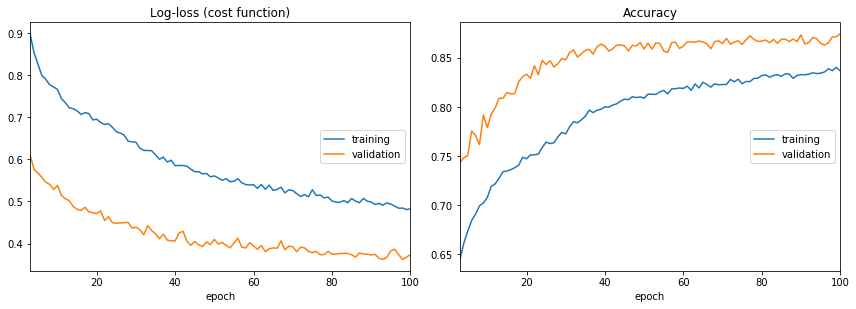

Log-loss (cost function):
training   (min:    0.481, max:    1.680, cur:    0.482)
validation (min:    0.362, max:    0.826, cur:    0.374)

Accuracy:
training   (min:    0.345, max:    0.840, cur:    0.837)
validation (min:    0.681, max:    0.874, cur:    0.874)


In [17]:
def create_mlp(args=None):
	# Define model architecture
    model = Sequential()
    model.add(Dense(256, input_shape = (784,), activation = 'relu'))
    model.add(Dropout(0.6))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(50, activation = 'relu'))
    model.add(BatchNormalization(momentum = .70))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    return model


def train_mlp(x_train, y_train, x_vali=None, y_vali=None, args=None):
    model_path = "best_mlp_ model.h5"
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   min_delta=0,
                                                   patience=50,
                                                   verbose=1,
                                                   mode='auto')

    MCP = keras.callbacks.ModelCheckpoint(
       model_path,
        monitor='val_acc',
        mode='max',
        verbose=1,
        save_best_only=True)
    # You can use args to pass parameter values to this method
    y_train = keras.utils.to_categorical(y_train, num_classes=10)
    model = create_mlp(args)
    with tf.device('/gpu:0'):
        model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.975, decay=2e-06, nesterov=True),
                  metrics=['accuracy'])

        sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                            log_device_placement=True))

        history = model.fit(x_train,y_train , batch_size= 256,
                       epochs=100, verbose=2, validation_split= .1, callbacks= [early_stopping, MCP, PlotLossesCallback()])
        sess.close()
        model = load_model(model_path) #Load best model from disc
        return model, history

model, history = train_mlp(x_train, y_train)


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 50)                6450      
_________________________________________________________________
batch_normalization_50 (Batc (None, 50)                200       
_________________________________________________________________
dense_68 (Dense)             (None, 50)                2550      
__________

Code for defining and training your CNN models

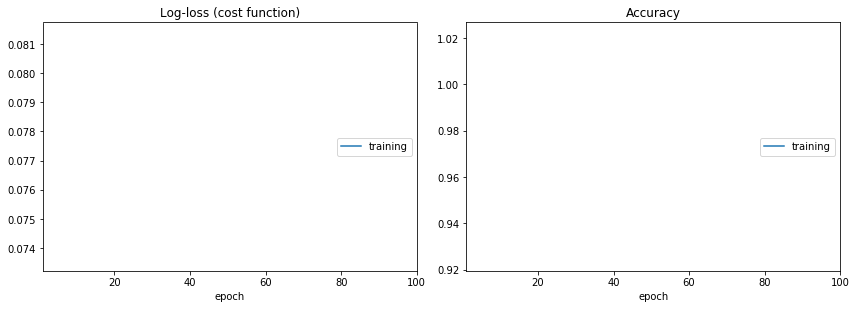

IndexError: list index out of range

In [58]:


from livelossplot.keras import PlotLossesCallback


def create_cnn(args=None):
    # 28x28 images with 1 color channel
    input_shape = (28, 28, 1)

    # Define model architecture
    model = Sequential()
    model.add(
        Conv2D(32, (3, 3),
               activation='relu',
               input_shape=input_shape,
               padding="same"))
    
    model.add(BatchNormalization()),
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')),
    model.add(BatchNormalization()),
    model.add(MaxPooling2D(pool_size=(2, 2))),
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')),
    model.add(BatchNormalization()),
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')),
    model.add(BatchNormalization()),        
    model.add(MaxPooling2D(pool_size=(2, 2))),
    model.add(Dropout(0.5))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')),
    model.add(BatchNormalization()),
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu')),
    model.add(BatchNormalization()),    
    model.add(MaxPooling2D(pool_size=(2, 2))),   

    model.add(Flatten()),
    
    model.add(Dense(1024, activation='relu')),
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu')),

    model.add(Dense(10, activation='softmax'))



    return model


def train_cnn(x_train, y_train, vali = 0.10, args=None):
    model_path = "best_cnn_model_v2.h5"
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   min_delta=0,
                                                   patience=50,
                                                   verbose=1,
                                                   mode='auto')

    MCP = keras.callbacks.ModelCheckpoint(
       model_path,
        monitor='val_acc',
        mode='max',
        verbose=1,
        save_best_only=True)
    # You can use args to pass parameter values to this method
    x_train = x_train.reshape(-1, 28, 28, 1)
    # You can use args to pass parameter values to this method
    y_train = keras.utils.to_categorical(y_train, num_classes=10)
    model = create_cnn(args)
    with tf.device('/gpu:0'):
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=0.0001, decay=1e-6),
                      metrics=['accuracy'])

        sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                log_device_placement=True))

        history = model.fit(x_train,
                            y_train,
                            batch_size=256,
                            epochs=100,
                            verbose=1,
                            validation_split=vali,
                            callbacks=[early_stopping, MCP, PlotLossesCallback()])
        sess.close()
        model = load_model(model_path)  #Load best model from disc
        
        history = model.fit(x_train,
                    y_train,
                    batch_size=256,
                    epochs=100,
                    verbose=1,
                    callbacks=[early_stopping, MCP, PlotLossesCallback()])
    return model, history


        
def train_cnn_augment(x_train, y_train, vali = 0.10, args=None):
    model_path = "best_cnn_model_augmentation.h5"
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   min_delta=0,
                                                   patience=50,
                                                   verbose=1,
                                                   mode='auto')

    MCP = keras.callbacks.ModelCheckpoint(
       model_path,
        monitor='val_acc',
        mode='max',
        verbose=1,
        save_best_only=True)
    # You can use args to pass parameter values to this method
    x_train = x_train.reshape(-1, 28, 28, 1)
    # You can use args to pass parameter values to this method
    y_train = keras.utils.to_categorical(y_train, num_classes=10)
    
    
    x_train, x_vali, y_train, y_vali = sklearn.model_selection.train_test_split(x_train, y_train, test_size = 0.1)
    
    train_datagen  = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
    
    
    
    model = create_cnn(args)
    with tf.device('/gpu:0'):
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=0.0001, decay=1e-6),
                      metrics=['accuracy'])

        sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                log_device_placement=True))
        
        
        history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train)/100, epochs=100, validation_data = (x_vali, y_vali))

        sess.close()
        model = load_model(model_path)  #Load best model from disc
    return model, history
    
    


model, history = train_cnn(x_train, y_train)
#model.summary()


In [54]:
    train_datagen  = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
x_train = x_train.reshape(-1, 28, 28, 1)

train_datagen.fl

An optional method you can use to repeatedly call create_mlp, train_mlp, create_cnn, or train_cnn. 
You can use it for performing cross validation or parameter searching.

Main method. Make sure the file paths here point to the correct place in your google drive.

In [22]:
grading_mode = True
PCA = False
if grading_mode:
# When we grade, we'll provide the file names as command-line arguments
    if (len(sys.argv) != 3):
        print("Usage:\n\tpython3 fashion.py train_file test_file")
        exit()
    #train_file = 'fashion_train.csv'
    #test_file = 'fashion_test.csv'
    train_file, test_file = sys.argv[1], sys.argv[2]
    x_train, y_train = get_data(train_file)
    x_test, y_test = get_data(test_file, shuff = False)
    
    x_test = x_test.reshape(-1, 28, 28, 1)
    # train your best model
    best_model = load_model('best_cnn_model_v2.h5')
    # use your best model to generate predictions for the test_file
    predictions = best_model.predict_classes(x_test)
    print('saving predictions to disc')
    output_predictions(predictions)
    
    if PCA:
        #PCA
        print('Running PCA + Logistic Regression')
        x_train, y_train = get_data(train_file)
        num_comp = [2,5,10,25,50,100]
        score_1 = {}
        for i in num_comp:
            train = PCA(n_components=i).fit_transform(x_train)
            model = LogisticRegression()
            score_1[i] = cross_validate(model, train, y_train, 
                              cv=5)
        scores = []
        fit_time = []

        score_1
        for i in score_1.keys():
            scores.append(np.mean(score_1[i]['test_score']))
            fit_time.append(np.mean(score_1[i]['fit_time']))
        
        sns.lineplot(x = num_comp, y = scores)
        plt.title('Cross Validation Accuracy (Holdout Set) on various Principle Components')
        plt.xlabel('Components')
        plt.ylabel('Accuracy on holdout')
        plt.show()

        sns.lineplot(x = num_comp, y = fit_time)
        plt.title('Cross Validation - Train Time')
        plt.xlabel('Components')
        plt.ylabel('Train Time in seconds')
        plt.show()

else:
    ### Edit the following two lines if your paths are different
    train_file = 'fashion_train.csv'
    test_file = 'fashion_test.csv'
    x_train, y_train = get_data(train_file)
    # MLP
    mlp_model, mlp_history = train_mlp(x_train, y_train)
    plot_history(mlp_history)
    visualize_weights(mlp_model)

    # CNN
    cnn_model, cnn_history = train_cnn(x_train, y_train)
    plot_history(cnn_history)

FileNotFoundError: [Errno 2] File b'-f' does not exist: b'-f'